### Training the Video Classification Model

### This script does - VGG16

In [1]:
import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import pickle

import time


 




C:\Users\jaghos\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\jaghos\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\jaghos\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.


In [2]:
Drive = "C:"
## Define root folder
RootFolder = Drive+"/1-GG/CAP4/EventDetection/1-ExampleSetting/OutputFiles"




In [3]:
trainFrames  = pd.read_csv(RootFolder+"/trainFrames.csv")

trainFrames.head()

,FrameFilename,FullPathName,class
0,MoreBasketBallVdo.mp4,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,Basketball
1,MoreBasketBallVdo.mp4,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,Basketball
2,MoreBasketBallVdo.mp4,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,Basketball
3,MoreBasketBallVdo.mp4,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,Basketball
4,MoreBasketBallVdo.mp4,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,Basketball


In [4]:
trainFrames.shape

(2767, 3)

In [5]:
# Get the unique values of 'class' column - How many distinct classes
model_class = trainFrames['class'].unique().tolist()
print(model_class)
model_output_size = len(model_class)
print(model_output_size)


['Basketball', 'SoccerPenalty']
2


In [6]:
trainFrames.shape[0]

2767

In [7]:
trainFrames['FullPathName'][0]

'C:/1-GG/CAP4/EventDetection/1-ExampleSetting\\VDOFrames/MoreBasketBallVdo_frame0.jpg'

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
from tqdm import tqdm
from keras.applications.vgg16 import VGG16
import cv2
import math
import os
from glob import glob
from scipy import stats as s

from moviepy.editor import *   ###VideoFileClip


## pafy, youtube-dl and moviepy packages to be installed
##pip install pafy youtube-dl moviepy

## Install open cv - make sure numpy already installed
#pip install opencv-python
#import pafy

from moviepy.editor import *   ###VideoFileClip


## pafy, youtube-dl and moviepy packages to be installed
##pip install pafy youtube-dl moviepy

## Install open cv - make sure numpy already installed
#pip install opencv-python
#import train_image 

In [9]:
train_image = []

# for loop to read and store frames
for i in tqdm(range(trainFrames.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    # three-dimensional array containing the red, green, and blue pixel intensities. 
    #Image has been reformated to be 224-by-224 pixels in size.
    img = image.load_img(trainFrames['FullPathName'][i], target_size=(224,224,3))
    #print(img.shape)
    # converting it to array
    img = image.img_to_array(img)
    
    # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)
    
# converting the list to numpy array
X = np.array(train_image)

# shape of the array
X.shape

100%|█████████████████████████████████████████████████████████████████████████████| 2767/2767 [00:09<00:00, 301.14it/s]


(2767, 224, 224, 3)

In [10]:
# make sure that the distribution of each class is similar in both training and validation sets. 
# We can use the stratify parameter

# separating the target
y = trainFrames['class']

# creating the training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify = y)

In [11]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

### Defining the architecture of the video classification model

### VGG16 on ImageNet

https://franky07724-57962.medium.com/using-keras-pre-trained-models-for-feature-extraction-in-image-clustering-a142c6cdf5b1


#### Keras provides a set of state-of-the-art deep learning models along with pre-trained weights on ImageNet. These pre-trained models can be used for image classification, feature extraction, and transfer learning

##### VGG16 refers to a VGG model with 16 weight layers, and VGG19 refers to a VGG model with 19 weight layers.  
#####  1.The input layer takes an image in the size of (224 x 224 x 3), and the output layer is a softmax prediction on classes.

#####  2.From the input layer to the last max pooling layer (labeled by 7 x 7 x 512) is regarded as the feature extraction part of the model, 

##### 3 while the rest of the network is regarded as the classification part of the model.

## VGG-16 pre-trained model will be used
### https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/

### creating the base model of pre-trained VGG16 model


In [12]:

# creating the base model of pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

### set include_top = False it overlooks the last 3 Fully Connected(FC) layers 


base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### vgg16 (without last 3 Fully Connected(FC)) is an impressively large neural network. It has 14,714,688 parameters. 
To see all paratemer use 
vgg19_full = VGG19(weights='imagenet')
vgg19_full.summary()

In [13]:

%%time
# extracting features for training frames
X_train = base_model.predict(X_train)
X_train.shape


Wall time: 30.3 s


(2213, 7, 7, 512)

In [14]:
%%time
# extracting features for validation frames
X_test = base_model.predict(X_test)
X_test.shape


Wall time: 8.22 s


(554, 7, 7, 512)

In [15]:
print(X_train.shape)
print(X_test.shape)
 
    

(2213, 7, 7, 512)
(554, 7, 7, 512)


There are 554 images in the test set and the shape of these images has also changed to (7, 7, 512). We will use a fully connected network now to fine-tune the model. This fully connected network takes input in single dimension. So, we will reshape the images into a single dimension:

In [16]:
X_train = X_train.reshape(X_train.shape[0], 7*7*512)
X_test = X_test.reshape(X_test.shape[0], 7*7*512)

In [17]:
# normalize the pixel values, i.e., keep the pixel values between 0 and 1. This helps the model to converge faster.

In [18]:
X_train.max()

10.913846

In [19]:
max = X_train.max()
X_train = X_train/max
X_test = X_test/max

In [20]:
# shape of images
X_train.shape

(2213, 25088)

### Keras Neural Network Sequential Model
##### More Info - https://faroit.com/keras-docs/1.0.1/getting-started/sequential-model-guide/

In [21]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(25088,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(model_output_size, activation='softmax'))  # model_output_size is 2 - already defined



###### 1 x Dense layer of 1024 units

###### 1 x Dense layer of 512 units
###### 1 x Dense layer of 256 units
###### 1 x Dense layer of 128 units


#### RELU activation for first four dense layers of  units to stop forwarding negative values through the network.

#### 2 unit dense layer in the end with softmax activation as there are 2 classes (model_output_size) to predict from in the end which are Basketball and SoccerPenalty. 
#### The softmax layer will output the value between 0 and 1 based on the confidence of the model that which class the images belongs to.

## Dropout
####   Usually, dropout is placed on the fully connected layers only because they are the one with the greater number of parameters and thus they're likely to excessively co-adapting themselves causing overfitting. However, since it's a stochastic regularization technique, you can really place it everywhere
#####  Dropout here has been applied applied to hidden neurons in the body of network model.
#### a dropout rate of 50% is used 

In [22]:
# Printing the models summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

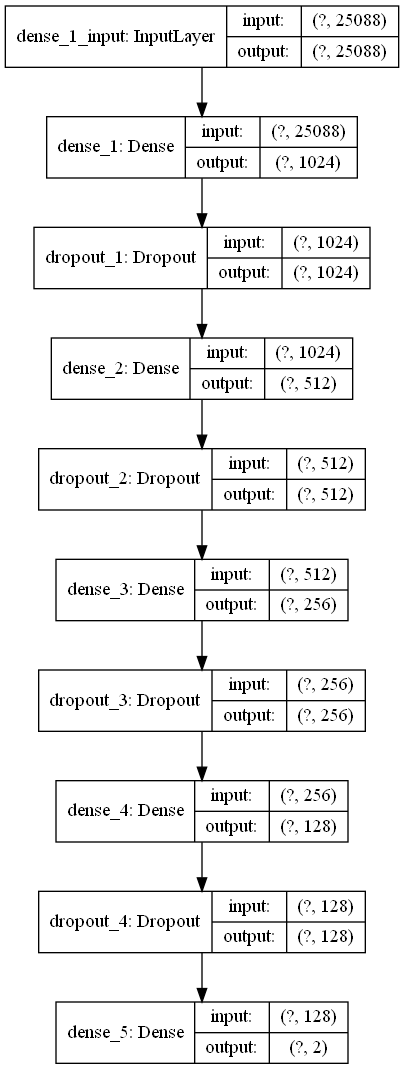

In [24]:
## Check Model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

#### ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

### -----

### save_best_only: if save_best_only=True, it only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten

### The metric name to monitormode: one of {'auto', 'min', 'max'}. If save_best_only=True, the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min

#### mode: one of {'auto', 'min', 'max'}. If save_best_only=True, -- the decision to overwrite the current save file is made based on either the maximization or the minimization  of the monitored quantity. For val_acc, this should be max, for val_loss this should be min

In [25]:
###Training the video classification model

# defining a function to save the weights of best model
### from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

mcp_save = ModelCheckpoint('weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')




#### using Adam optimiser 

In [26]:
# compiling the model - Adding loss, optimizer and metrics values to the model.
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])



In [27]:
%%time
# training the model
#model_training_history = model.fit( X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)

# Adding Early Stopping Callback
#early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

model_training_history = model.fit(x = X_train, y = y_train, epochs = 20, verbose = 1, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks=[mcp_save])

Train on 1770 samples, validate on 443 samples
Epoch 1/20


1444/1770 [=======================>......] - ETA: 3:37 - loss: 0.6591 - accuracy: 0.50 - ETA: 1:22 - loss: 0.8406 - accuracy: 0.41 - ETA: 56s - loss: 0.8428 - accuracy: 0.4500 - ETA: 44s - loss: 0.8136 - accuracy: 0.500 - ETA: 38s - loss: 0.8807 - accuracy: 0.472 - ETA: 34s - loss: 0.8885 - accuracy: 0.454 - ETA: 31s - loss: 0.8668 - accuracy: 0.480 - ETA: 29s - loss: 0.8489 - accuracy: 0.516 - ETA: 27s - loss: 0.8188 - accuracy: 0.544 - ETA: 26s - loss: 0.8304 - accuracy: 0.578 - ETA: 25s - loss: 0.8665 - accuracy: 0.571 - ETA: 24s - loss: 0.8737 - accuracy: 0.587 - ETA: 23s - loss: 0.8476 - accuracy: 0.600 - ETA: 22s - loss: 1.0006 - accuracy: 0.574 - ETA: 22s - loss: 1.0467 - accuracy: 0.569 - ETA: 21s - loss: 1.1215 - accuracy: 0.556 - ETA: 21s - loss: 1.1403 - accuracy: 0.545 - ETA: 20s - loss: 1.1981 - accuracy: 0.528 - ETA: 20s - loss: 1.1485 - accuracy: 0.547 - ETA: 20s - loss: 1.1472 - accuracy: 0.538 - ETA: 19s - loss: 1.1463 - accuracy: 0.548 - ETA: 19s - loss: 1.1712 - accu

1770/1770 [==============================] - ETA: 3s - loss: 0.6006 - accuracy: 0.72 - ETA: 3s - loss: 0.5992 - accuracy: 0.72 - ETA: 3s - loss: 0.5963 - accuracy: 0.72 - ETA: 3s - loss: 0.5931 - accuracy: 0.72 - ETA: 2s - loss: 0.5899 - accuracy: 0.73 - ETA: 2s - loss: 0.5875 - accuracy: 0.73 - ETA: 2s - loss: 0.5846 - accuracy: 0.73 - ETA: 2s - loss: 0.5817 - accuracy: 0.73 - ETA: 2s - loss: 0.5791 - accuracy: 0.73 - ETA: 2s - loss: 0.5782 - accuracy: 0.73 - ETA: 2s - loss: 0.5760 - accuracy: 0.73 - ETA: 2s - loss: 0.5732 - accuracy: 0.73 - ETA: 2s - loss: 0.5739 - accuracy: 0.73 - ETA: 2s - loss: 0.5719 - accuracy: 0.74 - ETA: 2s - loss: 0.5691 - accuracy: 0.74 - ETA: 2s - loss: 0.5664 - accuracy: 0.74 - ETA: 1s - loss: 0.5641 - accuracy: 0.74 - ETA: 1s - loss: 0.5615 - accuracy: 0.74 - ETA: 1s - loss: 0.5587 - accuracy: 0.74 - ETA: 1s - loss: 0.5574 - accuracy: 0.74 - ETA: 1s - loss: 0.5548 - accuracy: 0.74 - ETA: 1s - loss: 0.5540 - accuracy: 0.74 - ETA: 1s - loss: 0.5515 - accura

1116/1770 [=================>............] - ETA: 20s - loss: 0.0238 - accuracy: 1.000 - ETA: 22s - loss: 0.0707 - accuracy: 1.000 - ETA: 23s - loss: 0.0770 - accuracy: 1.000 - ETA: 24s - loss: 0.3064 - accuracy: 0.937 - ETA: 23s - loss: 0.3181 - accuracy: 0.900 - ETA: 22s - loss: 0.2671 - accuracy: 0.928 - ETA: 22s - loss: 0.2440 - accuracy: 0.937 - ETA: 25s - loss: 0.2170 - accuracy: 0.944 - ETA: 25s - loss: 0.1999 - accuracy: 0.950 - ETA: 25s - loss: 0.2572 - accuracy: 0.931 - ETA: 25s - loss: 0.2600 - accuracy: 0.916 - ETA: 25s - loss: 0.2852 - accuracy: 0.903 - ETA: 25s - loss: 0.2664 - accuracy: 0.910 - ETA: 25s - loss: 0.2488 - accuracy: 0.916 - ETA: 25s - loss: 0.2343 - accuracy: 0.921 - ETA: 25s - loss: 0.2212 - accuracy: 0.926 - ETA: 24s - loss: 0.2120 - accuracy: 0.930 - ETA: 24s - loss: 0.2045 - accuracy: 0.934 - ETA: 24s - loss: 0.1968 - accuracy: 0.937 - ETA: 24s - loss: 0.1883 - accuracy: 0.940 - ETA: 24s - loss: 0.1802 - accuracy: 0.943 - ETA: 24s - loss: 0.1733 - accur

1770/1770 [==============================] - ETA: 7s - loss: 0.1095 - accuracy: 0.96 - ETA: 7s - loss: 0.1178 - accuracy: 0.96 - ETA: 7s - loss: 0.1170 - accuracy: 0.96 - ETA: 7s - loss: 0.1198 - accuracy: 0.96 - ETA: 7s - loss: 0.1194 - accuracy: 0.96 - ETA: 7s - loss: 0.1187 - accuracy: 0.96 - ETA: 7s - loss: 0.1179 - accuracy: 0.96 - ETA: 6s - loss: 0.1178 - accuracy: 0.96 - ETA: 6s - loss: 0.1170 - accuracy: 0.96 - ETA: 6s - loss: 0.1171 - accuracy: 0.96 - ETA: 6s - loss: 0.1170 - accuracy: 0.96 - ETA: 6s - loss: 0.1172 - accuracy: 0.96 - ETA: 6s - loss: 0.1172 - accuracy: 0.96 - ETA: 6s - loss: 0.1165 - accuracy: 0.96 - ETA: 6s - loss: 0.1170 - accuracy: 0.96 - ETA: 6s - loss: 0.1163 - accuracy: 0.96 - ETA: 6s - loss: 0.1160 - accuracy: 0.96 - ETA: 5s - loss: 0.1153 - accuracy: 0.96 - ETA: 5s - loss: 0.1146 - accuracy: 0.96 - ETA: 5s - loss: 0.1144 - accuracy: 0.96 - ETA: 5s - loss: 0.1148 - accuracy: 0.96 - ETA: 5s - loss: 0.1149 - accuracy: 0.96 - ETA: 5s - loss: 0.1145 - accura

1256/1770 [====================>.........] - ETA: 20s - loss: 6.7409e-05 - accuracy: 1.000 - ETA: 19s - loss: 0.0509 - accuracy: 1.0000    - ETA: 18s - loss: 0.0612 - accuracy: 1.000 - ETA: 19s - loss: 0.0520 - accuracy: 1.000 - ETA: 19s - loss: 0.0393 - accuracy: 1.000 - ETA: 18s - loss: 0.0949 - accuracy: 0.975 - ETA: 18s - loss: 0.0913 - accuracy: 0.979 - ETA: 18s - loss: 0.2539 - accuracy: 0.946 - ETA: 17s - loss: 0.2989 - accuracy: 0.937 - ETA: 17s - loss: 0.2659 - accuracy: 0.944 - ETA: 17s - loss: 0.2460 - accuracy: 0.950 - ETA: 17s - loss: 0.2512 - accuracy: 0.943 - ETA: 17s - loss: 0.2418 - accuracy: 0.945 - ETA: 17s - loss: 0.2445 - accuracy: 0.940 - ETA: 17s - loss: 0.2292 - accuracy: 0.944 - ETA: 17s - loss: 0.2150 - accuracy: 0.948 - ETA: 17s - loss: 0.2021 - accuracy: 0.951 - ETA: 17s - loss: 0.2107 - accuracy: 0.939 - ETA: 16s - loss: 0.1994 - accuracy: 0.942 - ETA: 16s - loss: 0.1903 - accuracy: 0.945 - ETA: 16s - loss: 0.2160 - accuracy: 0.942 - ETA: 16s - loss: 0.2127

1770/1770 [==============================] - ETA: 5s - loss: 0.1281 - accuracy: 0.95 - ETA: 5s - loss: 0.1278 - accuracy: 0.95 - ETA: 5s - loss: 0.1274 - accuracy: 0.95 - ETA: 5s - loss: 0.1289 - accuracy: 0.95 - ETA: 5s - loss: 0.1285 - accuracy: 0.95 - ETA: 5s - loss: 0.1279 - accuracy: 0.95 - ETA: 5s - loss: 0.1275 - accuracy: 0.95 - ETA: 5s - loss: 0.1272 - accuracy: 0.95 - ETA: 5s - loss: 0.1265 - accuracy: 0.95 - ETA: 5s - loss: 0.1260 - accuracy: 0.95 - ETA: 5s - loss: 0.1263 - accuracy: 0.95 - ETA: 4s - loss: 0.1258 - accuracy: 0.95 - ETA: 4s - loss: 0.1250 - accuracy: 0.95 - ETA: 4s - loss: 0.1247 - accuracy: 0.95 - ETA: 4s - loss: 0.1241 - accuracy: 0.95 - ETA: 4s - loss: 0.1253 - accuracy: 0.95 - ETA: 4s - loss: 0.1246 - accuracy: 0.95 - ETA: 4s - loss: 0.1239 - accuracy: 0.95 - ETA: 4s - loss: 0.1234 - accuracy: 0.95 - ETA: 4s - loss: 0.1228 - accuracy: 0.95 - ETA: 4s - loss: 0.1225 - accuracy: 0.95 - ETA: 3s - loss: 0.1219 - accuracy: 0.95 - ETA: 3s - loss: 0.1212 - accura

1020/1770 [================>.............] - ETA: 17s - loss: 0.0013 - accuracy: 1.000 - ETA: 18s - loss: 0.1914 - accuracy: 0.916 - ETA: 19s - loss: 0.1958 - accuracy: 0.875 - ETA: 20s - loss: 0.1623 - accuracy: 0.900 - ETA: 19s - loss: 0.1522 - accuracy: 0.892 - ETA: 20s - loss: 0.1356 - accuracy: 0.906 - ETA: 19s - loss: 0.1100 - accuracy: 0.925 - ETA: 19s - loss: 0.0936 - accuracy: 0.937 - ETA: 19s - loss: 0.0873 - accuracy: 0.942 - ETA: 19s - loss: 0.0759 - accuracy: 0.950 - ETA: 19s - loss: 0.0711 - accuracy: 0.953 - ETA: 19s - loss: 0.0695 - accuracy: 0.958 - ETA: 19s - loss: 0.0671 - accuracy: 0.962 - ETA: 18s - loss: 0.0613 - accuracy: 0.965 - ETA: 18s - loss: 0.0689 - accuracy: 0.958 - ETA: 18s - loss: 0.1134 - accuracy: 0.951 - ETA: 18s - loss: 0.1092 - accuracy: 0.953 - ETA: 18s - loss: 0.1054 - accuracy: 0.955 - ETA: 18s - loss: 0.1041 - accuracy: 0.956 - ETA: 18s - loss: 0.0999 - accuracy: 0.959 - ETA: 18s - loss: 0.0987 - accuracy: 0.960 - ETA: 18s - loss: 0.0957 - accur

1770/1770 [==============================] - ETA: 8s - loss: 0.0878 - accuracy: 0.98 - ETA: 8s - loss: 0.0871 - accuracy: 0.98 - ETA: 8s - loss: 0.0865 - accuracy: 0.98 - ETA: 8s - loss: 0.0861 - accuracy: 0.98 - ETA: 8s - loss: 0.0858 - accuracy: 0.98 - ETA: 8s - loss: 0.0854 - accuracy: 0.98 - ETA: 8s - loss: 0.0872 - accuracy: 0.98 - ETA: 8s - loss: 0.0908 - accuracy: 0.98 - ETA: 8s - loss: 0.0906 - accuracy: 0.98 - ETA: 8s - loss: 0.0957 - accuracy: 0.97 - ETA: 8s - loss: 0.0954 - accuracy: 0.97 - ETA: 8s - loss: 0.0951 - accuracy: 0.97 - ETA: 8s - loss: 0.0947 - accuracy: 0.97 - ETA: 8s - loss: 0.0944 - accuracy: 0.97 - ETA: 8s - loss: 0.0939 - accuracy: 0.98 - ETA: 7s - loss: 0.0978 - accuracy: 0.97 - ETA: 7s - loss: 0.0986 - accuracy: 0.97 - ETA: 7s - loss: 0.0996 - accuracy: 0.97 - ETA: 7s - loss: 0.0995 - accuracy: 0.97 - ETA: 7s - loss: 0.0990 - accuracy: 0.97 - ETA: 7s - loss: 0.0996 - accuracy: 0.97 - ETA: 7s - loss: 0.0991 - accuracy: 0.97 - ETA: 7s - loss: 0.1012 - accura

1440/1770 [=======================>......] - ETA: 15s - loss: 0.0085 - accuracy: 1.000 - ETA: 16s - loss: 0.0787 - accuracy: 1.000 - ETA: 17s - loss: 0.0507 - accuracy: 1.000 - ETA: 17s - loss: 0.0400 - accuracy: 1.000 - ETA: 17s - loss: 0.0347 - accuracy: 1.000 - ETA: 17s - loss: 0.0317 - accuracy: 1.000 - ETA: 18s - loss: 0.0333 - accuracy: 1.000 - ETA: 18s - loss: 0.0305 - accuracy: 1.000 - ETA: 18s - loss: 0.0341 - accuracy: 1.000 - ETA: 18s - loss: 0.0299 - accuracy: 1.000 - ETA: 18s - loss: 0.0328 - accuracy: 1.000 - ETA: 17s - loss: 0.0296 - accuracy: 1.000 - ETA: 17s - loss: 0.0313 - accuracy: 1.000 - ETA: 17s - loss: 0.0289 - accuracy: 1.000 - ETA: 17s - loss: 0.0337 - accuracy: 0.990 - ETA: 17s - loss: 0.0323 - accuracy: 0.991 - ETA: 16s - loss: 0.0302 - accuracy: 0.991 - ETA: 16s - loss: 0.0288 - accuracy: 0.992 - ETA: 16s - loss: 0.0272 - accuracy: 0.992 - ETA: 16s - loss: 0.0258 - accuracy: 0.993 - ETA: 16s - loss: 0.0245 - accuracy: 0.993 - ETA: 16s - loss: 0.0235 - accur

1770/1770 [==============================] - ETA: 3s - loss: 0.0431 - accuracy: 0.98 - ETA: 3s - loss: 0.0431 - accuracy: 0.98 - ETA: 3s - loss: 0.0430 - accuracy: 0.98 - ETA: 3s - loss: 0.0427 - accuracy: 0.98 - ETA: 2s - loss: 0.0425 - accuracy: 0.98 - ETA: 2s - loss: 0.0425 - accuracy: 0.98 - ETA: 2s - loss: 0.0424 - accuracy: 0.98 - ETA: 2s - loss: 0.0423 - accuracy: 0.98 - ETA: 2s - loss: 0.0421 - accuracy: 0.98 - ETA: 2s - loss: 0.0419 - accuracy: 0.98 - ETA: 2s - loss: 0.0417 - accuracy: 0.98 - ETA: 2s - loss: 0.0415 - accuracy: 0.98 - ETA: 2s - loss: 0.0438 - accuracy: 0.98 - ETA: 2s - loss: 0.0437 - accuracy: 0.98 - ETA: 2s - loss: 0.0435 - accuracy: 0.98 - ETA: 2s - loss: 0.0436 - accuracy: 0.98 - ETA: 2s - loss: 0.0434 - accuracy: 0.98 - ETA: 2s - loss: 0.0433 - accuracy: 0.98 - ETA: 2s - loss: 0.0437 - accuracy: 0.98 - ETA: 2s - loss: 0.0436 - accuracy: 0.98 - ETA: 1s - loss: 0.0435 - accuracy: 0.98 - ETA: 1s - loss: 0.0432 - accuracy: 0.98 - ETA: 1s - loss: 0.0436 - accura

1516/1770 [========================>.....] - ETA: 15s - loss: 0.0109 - accuracy: 1.000 - ETA: 15s - loss: 0.0116 - accuracy: 1.000 - ETA: 15s - loss: 0.0693 - accuracy: 0.950 - ETA: 15s - loss: 0.0633 - accuracy: 0.964 - ETA: 15s - loss: 0.0505 - accuracy: 0.972 - ETA: 15s - loss: 0.0415 - accuracy: 0.977 - ETA: 15s - loss: 0.0351 - accuracy: 0.980 - ETA: 15s - loss: 0.0314 - accuracy: 0.983 - ETA: 15s - loss: 0.0284 - accuracy: 0.985 - ETA: 15s - loss: 0.0301 - accuracy: 0.986 - ETA: 15s - loss: 0.0283 - accuracy: 0.988 - ETA: 15s - loss: 0.0284 - accuracy: 0.989 - ETA: 15s - loss: 0.0262 - accuracy: 0.990 - ETA: 15s - loss: 0.0246 - accuracy: 0.990 - ETA: 15s - loss: 0.0236 - accuracy: 0.991 - ETA: 15s - loss: 0.0409 - accuracy: 0.983 - ETA: 15s - loss: 0.0387 - accuracy: 0.984 - ETA: 14s - loss: 0.0368 - accuracy: 0.985 - ETA: 14s - loss: 0.0348 - accuracy: 0.986 - ETA: 14s - loss: 0.0337 - accuracy: 0.987 - ETA: 14s - loss: 0.0321 - accuracy: 0.987 - ETA: 14s - loss: 0.0359 - accur

1770/1770 [==============================] - ETA: 2s - loss: 0.0480 - accuracy: 0.98 - ETA: 2s - loss: 0.0482 - accuracy: 0.98 - ETA: 2s - loss: 0.0479 - accuracy: 0.98 - ETA: 2s - loss: 0.0477 - accuracy: 0.98 - ETA: 1s - loss: 0.0475 - accuracy: 0.98 - ETA: 1s - loss: 0.0473 - accuracy: 0.98 - ETA: 1s - loss: 0.0471 - accuracy: 0.98 - ETA: 1s - loss: 0.0469 - accuracy: 0.98 - ETA: 1s - loss: 0.0468 - accuracy: 0.98 - ETA: 1s - loss: 0.0465 - accuracy: 0.98 - ETA: 1s - loss: 0.0463 - accuracy: 0.98 - ETA: 1s - loss: 0.0461 - accuracy: 0.98 - ETA: 1s - loss: 0.0459 - accuracy: 0.98 - ETA: 1s - loss: 0.0456 - accuracy: 0.98 - ETA: 1s - loss: 0.0454 - accuracy: 0.98 - ETA: 1s - loss: 0.0484 - accuracy: 0.98 - ETA: 1s - loss: 0.0483 - accuracy: 0.98 - ETA: 1s - loss: 0.0481 - accuracy: 0.98 - ETA: 0s - loss: 0.0479 - accuracy: 0.98 - ETA: 0s - loss: 0.0477 - accuracy: 0.98 - ETA: 0s - loss: 0.0481 - accuracy: 0.98 - ETA: 0s - loss: 0.0479 - accuracy: 0.98 - ETA: 0s - loss: 0.0477 - accura

1512/1770 [========================>.....] - ETA: 15s - loss: 8.9407e-08 - accuracy: 1.000 - ETA: 16s - loss: 0.0461 - accuracy: 1.0000    - ETA: 16s - loss: 0.0280 - accuracy: 1.000 - ETA: 16s - loss: 0.0200 - accuracy: 1.000 - ETA: 16s - loss: 0.0204 - accuracy: 1.000 - ETA: 16s - loss: 0.0167 - accuracy: 1.000 - ETA: 16s - loss: 0.0159 - accuracy: 1.000 - ETA: 16s - loss: 0.0369 - accuracy: 0.983 - ETA: 15s - loss: 0.0326 - accuracy: 0.985 - ETA: 15s - loss: 0.0315 - accuracy: 0.986 - ETA: 15s - loss: 0.0679 - accuracy: 0.964 - ETA: 15s - loss: 0.0627 - accuracy: 0.967 - ETA: 15s - loss: 0.0579 - accuracy: 0.970 - ETA: 15s - loss: 0.0734 - accuracy: 0.963 - ETA: 15s - loss: 0.0778 - accuracy: 0.965 - ETA: 15s - loss: 0.0793 - accuracy: 0.959 - ETA: 15s - loss: 0.0790 - accuracy: 0.962 - ETA: 15s - loss: 0.0761 - accuracy: 0.964 - ETA: 15s - loss: 0.0835 - accuracy: 0.959 - ETA: 15s - loss: 0.0806 - accuracy: 0.961 - ETA: 15s - loss: 0.0940 - accuracy: 0.957 - ETA: 14s - loss: 0.0928

1770/1770 [==============================] - ETA: 2s - loss: 0.0573 - accuracy: 0.98 - ETA: 2s - loss: 0.0570 - accuracy: 0.98 - ETA: 2s - loss: 0.0567 - accuracy: 0.98 - ETA: 2s - loss: 0.0564 - accuracy: 0.98 - ETA: 2s - loss: 0.0561 - accuracy: 0.98 - ETA: 1s - loss: 0.0558 - accuracy: 0.98 - ETA: 1s - loss: 0.0555 - accuracy: 0.98 - ETA: 1s - loss: 0.0553 - accuracy: 0.98 - ETA: 1s - loss: 0.0550 - accuracy: 0.98 - ETA: 1s - loss: 0.0547 - accuracy: 0.98 - ETA: 1s - loss: 0.0545 - accuracy: 0.98 - ETA: 1s - loss: 0.0542 - accuracy: 0.98 - ETA: 1s - loss: 0.0539 - accuracy: 0.98 - ETA: 1s - loss: 0.0537 - accuracy: 0.98 - ETA: 1s - loss: 0.0535 - accuracy: 0.98 - ETA: 1s - loss: 0.0533 - accuracy: 0.98 - ETA: 1s - loss: 0.0530 - accuracy: 0.98 - ETA: 1s - loss: 0.0528 - accuracy: 0.98 - ETA: 1s - loss: 0.0525 - accuracy: 0.98 - ETA: 0s - loss: 0.0561 - accuracy: 0.98 - ETA: 0s - loss: 0.0559 - accuracy: 0.98 - ETA: 0s - loss: 0.0556 - accuracy: 0.98 - ETA: 0s - loss: 0.0555 - accura

1280/1770 [====================>.........] - ETA: 15s - loss: 1.2974e-04 - accuracy: 1.000 - ETA: 16s - loss: 0.0448 - accuracy: 1.0000    - ETA: 16s - loss: 0.0816 - accuracy: 1.000 - ETA: 17s - loss: 0.0830 - accuracy: 0.964 - ETA: 17s - loss: 0.0693 - accuracy: 0.972 - ETA: 16s - loss: 0.0571 - accuracy: 0.977 - ETA: 16s - loss: 0.0485 - accuracy: 0.980 - ETA: 16s - loss: 0.0431 - accuracy: 0.983 - ETA: 16s - loss: 0.0381 - accuracy: 0.985 - ETA: 16s - loss: 0.0359 - accuracy: 0.986 - ETA: 16s - loss: 0.0372 - accuracy: 0.988 - ETA: 16s - loss: 0.0340 - accuracy: 0.989 - ETA: 16s - loss: 0.0314 - accuracy: 0.990 - ETA: 15s - loss: 0.0293 - accuracy: 0.990 - ETA: 15s - loss: 0.0273 - accuracy: 0.991 - ETA: 15s - loss: 0.0256 - accuracy: 0.991 - ETA: 15s - loss: 0.0241 - accuracy: 0.992 - ETA: 15s - loss: 0.0400 - accuracy: 0.985 - ETA: 15s - loss: 0.0392 - accuracy: 0.986 - ETA: 15s - loss: 0.0373 - accuracy: 0.987 - ETA: 15s - loss: 0.0355 - accuracy: 0.987 - ETA: 15s - loss: 0.0341

1770/1770 [==============================] - ETA: 5s - loss: 0.0282 - accuracy: 0.99 - ETA: 5s - loss: 0.0281 - accuracy: 0.99 - ETA: 5s - loss: 0.0281 - accuracy: 0.99 - ETA: 5s - loss: 0.0297 - accuracy: 0.99 - ETA: 5s - loss: 0.0296 - accuracy: 0.99 - ETA: 5s - loss: 0.0295 - accuracy: 0.99 - ETA: 5s - loss: 0.0294 - accuracy: 0.99 - ETA: 4s - loss: 0.0293 - accuracy: 0.99 - ETA: 4s - loss: 0.0307 - accuracy: 0.98 - ETA: 4s - loss: 0.0306 - accuracy: 0.98 - ETA: 4s - loss: 0.0305 - accuracy: 0.98 - ETA: 4s - loss: 0.0304 - accuracy: 0.98 - ETA: 4s - loss: 0.0303 - accuracy: 0.98 - ETA: 4s - loss: 0.0302 - accuracy: 0.98 - ETA: 4s - loss: 0.0301 - accuracy: 0.98 - ETA: 4s - loss: 0.0300 - accuracy: 0.98 - ETA: 4s - loss: 0.0300 - accuracy: 0.98 - ETA: 4s - loss: 0.0299 - accuracy: 0.98 - ETA: 4s - loss: 0.0299 - accuracy: 0.98 - ETA: 4s - loss: 0.0298 - accuracy: 0.98 - ETA: 4s - loss: 0.0297 - accuracy: 0.98 - ETA: 4s - loss: 0.0295 - accuracy: 0.98 - ETA: 4s - loss: 0.0294 - accura

1512/1770 [========================>.....] - ETA: 15s - loss: 0.0066 - accuracy: 1.000 - ETA: 15s - loss: 0.0115 - accuracy: 1.000 - ETA: 16s - loss: 0.0077 - accuracy: 1.000 - ETA: 16s - loss: 0.0063 - accuracy: 1.000 - ETA: 16s - loss: 0.0056 - accuracy: 1.000 - ETA: 16s - loss: 0.0815 - accuracy: 0.977 - ETA: 16s - loss: 0.0714 - accuracy: 0.980 - ETA: 15s - loss: 0.0622 - accuracy: 0.983 - ETA: 15s - loss: 0.0548 - accuracy: 0.985 - ETA: 15s - loss: 0.0536 - accuracy: 0.986 - ETA: 15s - loss: 0.0485 - accuracy: 0.988 - ETA: 15s - loss: 0.0445 - accuracy: 0.989 - ETA: 15s - loss: 0.0520 - accuracy: 0.980 - ETA: 15s - loss: 0.0492 - accuracy: 0.981 - ETA: 15s - loss: 0.0467 - accuracy: 0.982 - ETA: 15s - loss: 0.0445 - accuracy: 0.983 - ETA: 15s - loss: 0.0438 - accuracy: 0.984 - ETA: 15s - loss: 0.0420 - accuracy: 0.985 - ETA: 15s - loss: 0.0398 - accuracy: 0.986 - ETA: 15s - loss: 0.0379 - accuracy: 0.987 - ETA: 14s - loss: 0.0365 - accuracy: 0.987 - ETA: 14s - loss: 0.0348 - accur

1770/1770 [==============================] - ETA: 2s - loss: 0.0097 - accuracy: 0.99 - ETA: 2s - loss: 0.0097 - accuracy: 0.99 - ETA: 2s - loss: 0.0096 - accuracy: 0.99 - ETA: 2s - loss: 0.0168 - accuracy: 0.99 - ETA: 2s - loss: 0.0168 - accuracy: 0.99 - ETA: 1s - loss: 0.0167 - accuracy: 0.99 - ETA: 1s - loss: 0.0166 - accuracy: 0.99 - ETA: 1s - loss: 0.0165 - accuracy: 0.99 - ETA: 1s - loss: 0.0164 - accuracy: 0.99 - ETA: 1s - loss: 0.0163 - accuracy: 0.99 - ETA: 1s - loss: 0.0248 - accuracy: 0.99 - ETA: 1s - loss: 0.0250 - accuracy: 0.99 - ETA: 1s - loss: 0.0249 - accuracy: 0.99 - ETA: 1s - loss: 0.0255 - accuracy: 0.99 - ETA: 1s - loss: 0.0256 - accuracy: 0.99 - ETA: 1s - loss: 0.0256 - accuracy: 0.99 - ETA: 1s - loss: 0.0259 - accuracy: 0.99 - ETA: 1s - loss: 0.0260 - accuracy: 0.99 - ETA: 0s - loss: 0.0260 - accuracy: 0.99 - ETA: 0s - loss: 0.0259 - accuracy: 0.99 - ETA: 0s - loss: 0.0258 - accuracy: 0.99 - ETA: 0s - loss: 0.0257 - accuracy: 0.99 - ETA: 0s - loss: 0.0255 - accura

1452/1770 [=======================>......] - ETA: 15s - loss: 5.3103e-05 - accuracy: 1.000 - ETA: 15s - loss: 9.8407e-05 - accuracy: 1.000 - ETA: 15s - loss: 0.0092 - accuracy: 1.0000    - ETA: 15s - loss: 0.0066 - accuracy: 1.000 - ETA: 15s - loss: 0.0053 - accuracy: 1.000 - ETA: 15s - loss: 0.0058 - accuracy: 1.000 - ETA: 15s - loss: 0.0051 - accuracy: 1.000 - ETA: 15s - loss: 0.0046 - accuracy: 1.000 - ETA: 15s - loss: 0.0047 - accuracy: 1.000 - ETA: 15s - loss: 0.0042 - accuracy: 1.000 - ETA: 15s - loss: 0.0038 - accuracy: 1.000 - ETA: 15s - loss: 0.0037 - accuracy: 1.000 - ETA: 15s - loss: 0.0034 - accuracy: 1.000 - ETA: 15s - loss: 0.0032 - accuracy: 1.000 - ETA: 15s - loss: 0.0030 - accuracy: 1.000 - ETA: 15s - loss: 0.0028 - accuracy: 1.000 - ETA: 15s - loss: 0.0026 - accuracy: 1.000 - ETA: 15s - loss: 0.0025 - accuracy: 1.000 - ETA: 15s - loss: 0.0049 - accuracy: 1.000 - ETA: 14s - loss: 0.0048 - accuracy: 1.000 - ETA: 14s - loss: 0.0057 - accuracy: 1.000 - ETA: 14s - loss: 0.

1770/1770 [==============================] - ETA: 2s - loss: 0.0333 - accuracy: 0.98 - ETA: 2s - loss: 0.0332 - accuracy: 0.98 - ETA: 2s - loss: 0.0330 - accuracy: 0.98 - ETA: 2s - loss: 0.0328 - accuracy: 0.98 - ETA: 2s - loss: 0.0327 - accuracy: 0.98 - ETA: 2s - loss: 0.0325 - accuracy: 0.99 - ETA: 2s - loss: 0.0359 - accuracy: 0.98 - ETA: 2s - loss: 0.0370 - accuracy: 0.98 - ETA: 2s - loss: 0.0368 - accuracy: 0.98 - ETA: 2s - loss: 0.0376 - accuracy: 0.98 - ETA: 2s - loss: 0.0376 - accuracy: 0.98 - ETA: 2s - loss: 0.0374 - accuracy: 0.98 - ETA: 2s - loss: 0.0372 - accuracy: 0.98 - ETA: 1s - loss: 0.0370 - accuracy: 0.98 - ETA: 1s - loss: 0.0369 - accuracy: 0.98 - ETA: 1s - loss: 0.0367 - accuracy: 0.98 - ETA: 1s - loss: 0.0365 - accuracy: 0.98 - ETA: 1s - loss: 0.0364 - accuracy: 0.98 - ETA: 1s - loss: 0.0362 - accuracy: 0.98 - ETA: 1s - loss: 0.0363 - accuracy: 0.98 - ETA: 1s - loss: 0.0362 - accuracy: 0.98 - ETA: 1s - loss: 0.0360 - accuracy: 0.98 - ETA: 1s - loss: 0.0360 - accura

1512/1770 [========================>.....] - ETA: 15s - loss: 0.1773 - accuracy: 0.750 - ETA: 15s - loss: 0.0592 - accuracy: 0.916 - ETA: 16s - loss: 0.0946 - accuracy: 0.900 - ETA: 16s - loss: 0.1696 - accuracy: 0.892 - ETA: 16s - loss: 0.1384 - accuracy: 0.916 - ETA: 16s - loss: 0.1135 - accuracy: 0.931 - ETA: 15s - loss: 0.1081 - accuracy: 0.942 - ETA: 15s - loss: 0.1066 - accuracy: 0.950 - ETA: 15s - loss: 0.0946 - accuracy: 0.955 - ETA: 15s - loss: 0.0956 - accuracy: 0.947 - ETA: 15s - loss: 0.0872 - accuracy: 0.952 - ETA: 15s - loss: 0.0939 - accuracy: 0.945 - ETA: 15s - loss: 0.0864 - accuracy: 0.950 - ETA: 15s - loss: 0.0800 - accuracy: 0.953 - ETA: 15s - loss: 0.0885 - accuracy: 0.948 - ETA: 15s - loss: 0.0829 - accuracy: 0.951 - ETA: 15s - loss: 0.0779 - accuracy: 0.954 - ETA: 15s - loss: 0.1131 - accuracy: 0.950 - ETA: 15s - loss: 0.1072 - accuracy: 0.952 - ETA: 15s - loss: 0.1085 - accuracy: 0.948 - ETA: 14s - loss: 0.1032 - accuracy: 0.951 - ETA: 14s - loss: 0.1025 - accur

1770/1770 [==============================] - ETA: 2s - loss: 0.0517 - accuracy: 0.98 - ETA: 2s - loss: 0.0515 - accuracy: 0.98 - ETA: 2s - loss: 0.0513 - accuracy: 0.98 - ETA: 2s - loss: 0.0511 - accuracy: 0.98 - ETA: 2s - loss: 0.0508 - accuracy: 0.98 - ETA: 1s - loss: 0.0506 - accuracy: 0.98 - ETA: 1s - loss: 0.0505 - accuracy: 0.98 - ETA: 1s - loss: 0.0503 - accuracy: 0.98 - ETA: 1s - loss: 0.0502 - accuracy: 0.98 - ETA: 1s - loss: 0.0501 - accuracy: 0.98 - ETA: 1s - loss: 0.0499 - accuracy: 0.98 - ETA: 1s - loss: 0.0498 - accuracy: 0.98 - ETA: 1s - loss: 0.0497 - accuracy: 0.98 - ETA: 1s - loss: 0.0495 - accuracy: 0.98 - ETA: 1s - loss: 0.0492 - accuracy: 0.98 - ETA: 1s - loss: 0.0490 - accuracy: 0.98 - ETA: 1s - loss: 0.0497 - accuracy: 0.98 - ETA: 1s - loss: 0.0495 - accuracy: 0.98 - ETA: 1s - loss: 0.0492 - accuracy: 0.98 - ETA: 1s - loss: 0.0490 - accuracy: 0.98 - ETA: 1s - loss: 0.0491 - accuracy: 0.98 - ETA: 1s - loss: 0.0489 - accuracy: 0.98 - ETA: 0s - loss: 0.0487 - accura

1088/1770 [=================>............] - ETA: 15s - loss: 9.6690e-05 - accuracy: 1.000 - ETA: 15s - loss: 3.4525e-05 - accuracy: 1.000 - ETA: 18s - loss: 2.7555e-05 - accuracy: 1.000 - ETA: 19s - loss: 2.2044e-05 - accuracy: 1.000 - ETA: 20s - loss: 0.0403 - accuracy: 0.9583    - ETA: 20s - loss: 0.0346 - accuracy: 0.964 - ETA: 20s - loss: 0.0374 - accuracy: 0.968 - ETA: 21s - loss: 0.0333 - accuracy: 0.972 - ETA: 21s - loss: 0.0299 - accuracy: 0.975 - ETA: 20s - loss: 0.0250 - accuracy: 0.979 - ETA: 20s - loss: 0.0231 - accuracy: 0.980 - ETA: 20s - loss: 0.0200 - accuracy: 0.983 - ETA: 19s - loss: 0.0177 - accuracy: 0.985 - ETA: 19s - loss: 0.0158 - accuracy: 0.986 - ETA: 19s - loss: 0.0143 - accuracy: 0.988 - ETA: 19s - loss: 0.0202 - accuracy: 0.988 - ETA: 19s - loss: 0.0497 - accuracy: 0.967 - ETA: 19s - loss: 0.0482 - accuracy: 0.968 - ETA: 19s - loss: 0.0462 - accuracy: 0.970 - ETA: 19s - loss: 0.0462 - accuracy: 0.971 - ETA: 19s - loss: 0.0445 - accuracy: 0.972 - ETA: 19s - 

1770/1770 [==============================] - ETA: 8s - loss: 0.0587 - accuracy: 0.98 - ETA: 8s - loss: 0.0583 - accuracy: 0.98 - ETA: 8s - loss: 0.0579 - accuracy: 0.98 - ETA: 7s - loss: 0.0574 - accuracy: 0.98 - ETA: 7s - loss: 0.0570 - accuracy: 0.98 - ETA: 7s - loss: 0.0567 - accuracy: 0.98 - ETA: 7s - loss: 0.0564 - accuracy: 0.98 - ETA: 7s - loss: 0.0560 - accuracy: 0.98 - ETA: 7s - loss: 0.0556 - accuracy: 0.98 - ETA: 7s - loss: 0.0553 - accuracy: 0.98 - ETA: 7s - loss: 0.0550 - accuracy: 0.98 - ETA: 7s - loss: 0.0546 - accuracy: 0.98 - ETA: 6s - loss: 0.0545 - accuracy: 0.98 - ETA: 6s - loss: 0.0541 - accuracy: 0.98 - ETA: 6s - loss: 0.0538 - accuracy: 0.98 - ETA: 6s - loss: 0.0534 - accuracy: 0.98 - ETA: 6s - loss: 0.0531 - accuracy: 0.98 - ETA: 6s - loss: 0.0528 - accuracy: 0.98 - ETA: 6s - loss: 0.0525 - accuracy: 0.98 - ETA: 6s - loss: 0.0522 - accuracy: 0.98 - ETA: 6s - loss: 0.0519 - accuracy: 0.98 - ETA: 6s - loss: 0.0519 - accuracy: 0.98 - ETA: 5s - loss: 0.0516 - accura

1160/1770 [==================>...........] - ETA: 15s - loss: 1.0995e-04 - accuracy: 1.000 - ETA: 16s - loss: 4.0841e-05 - accuracy: 1.000 - ETA: 16s - loss: 3.2569e-05 - accuracy: 1.000 - ETA: 16s - loss: 1.6306e-04 - accuracy: 1.000 - ETA: 16s - loss: 0.0392 - accuracy: 0.9722    - ETA: 16s - loss: 0.0365 - accuracy: 0.977 - ETA: 16s - loss: 0.0343 - accuracy: 0.980 - ETA: 16s - loss: 0.0320 - accuracy: 0.983 - ETA: 16s - loss: 0.0282 - accuracy: 0.985 - ETA: 16s - loss: 0.0253 - accuracy: 0.986 - ETA: 16s - loss: 0.0229 - accuracy: 0.988 - ETA: 16s - loss: 0.0216 - accuracy: 0.989 - ETA: 16s - loss: 0.0198 - accuracy: 0.990 - ETA: 16s - loss: 0.0209 - accuracy: 0.990 - ETA: 16s - loss: 0.0195 - accuracy: 0.991 - ETA: 16s - loss: 0.0183 - accuracy: 0.991 - ETA: 15s - loss: 0.0172 - accuracy: 0.992 - ETA: 15s - loss: 0.0162 - accuracy: 0.992 - ETA: 15s - loss: 0.0155 - accuracy: 0.993 - ETA: 15s - loss: 0.0147 - accuracy: 0.993 - ETA: 15s - loss: 0.0143 - accuracy: 0.993 - ETA: 15s - 

1770/1770 [==============================] - ETA: 6s - loss: 0.0300 - accuracy: 0.98 - ETA: 6s - loss: 0.0299 - accuracy: 0.98 - ETA: 6s - loss: 0.0298 - accuracy: 0.98 - ETA: 6s - loss: 0.0297 - accuracy: 0.98 - ETA: 6s - loss: 0.0296 - accuracy: 0.98 - ETA: 6s - loss: 0.0308 - accuracy: 0.98 - ETA: 6s - loss: 0.0307 - accuracy: 0.98 - ETA: 6s - loss: 0.0306 - accuracy: 0.98 - ETA: 6s - loss: 0.0305 - accuracy: 0.98 - ETA: 6s - loss: 0.0304 - accuracy: 0.98 - ETA: 6s - loss: 0.0303 - accuracy: 0.98 - ETA: 6s - loss: 0.0301 - accuracy: 0.98 - ETA: 6s - loss: 0.0300 - accuracy: 0.98 - ETA: 6s - loss: 0.0299 - accuracy: 0.98 - ETA: 6s - loss: 0.0298 - accuracy: 0.98 - ETA: 6s - loss: 0.0297 - accuracy: 0.98 - ETA: 6s - loss: 0.0296 - accuracy: 0.98 - ETA: 6s - loss: 0.0295 - accuracy: 0.98 - ETA: 6s - loss: 0.0294 - accuracy: 0.98 - ETA: 5s - loss: 0.0310 - accuracy: 0.98 - ETA: 5s - loss: 0.0309 - accuracy: 0.98 - ETA: 5s - loss: 0.0308 - accuracy: 0.98 - ETA: 5s - loss: 0.0306 - accura

1364/1770 [======================>.......] - ETA: 16s - loss: 7.8677e-06 - accuracy: 1.000 - ETA: 17s - loss: 2.6226e-06 - accuracy: 1.000 - ETA: 17s - loss: 1.7404e-06 - accuracy: 1.000 - ETA: 17s - loss: 8.2513e-04 - accuracy: 1.000 - ETA: 17s - loss: 6.4193e-04 - accuracy: 1.000 - ETA: 16s - loss: 0.0106 - accuracy: 1.0000    - ETA: 17s - loss: 0.0097 - accuracy: 1.000 - ETA: 17s - loss: 0.0083 - accuracy: 1.000 - ETA: 17s - loss: 0.0073 - accuracy: 1.000 - ETA: 16s - loss: 0.0065 - accuracy: 1.000 - ETA: 16s - loss: 0.0058 - accuracy: 1.000 - ETA: 16s - loss: 0.0055 - accuracy: 1.000 - ETA: 16s - loss: 0.0050 - accuracy: 1.000 - ETA: 16s - loss: 0.0047 - accuracy: 1.000 - ETA: 16s - loss: 0.0070 - accuracy: 1.000 - ETA: 16s - loss: 0.0069 - accuracy: 1.000 - ETA: 16s - loss: 0.0065 - accuracy: 1.000 - ETA: 15s - loss: 0.0066 - accuracy: 1.000 - ETA: 15s - loss: 0.0063 - accuracy: 1.000 - ETA: 15s - loss: 0.0060 - accuracy: 1.000 - ETA: 15s - loss: 0.0057 - accuracy: 1.000 - ETA: 15

1770/1770 [==============================] - ETA: 4s - loss: 0.0606 - accuracy: 0.98 - ETA: 4s - loss: 0.0651 - accuracy: 0.98 - ETA: 3s - loss: 0.0652 - accuracy: 0.98 - ETA: 3s - loss: 0.0648 - accuracy: 0.98 - ETA: 3s - loss: 0.0644 - accuracy: 0.98 - ETA: 3s - loss: 0.0641 - accuracy: 0.98 - ETA: 3s - loss: 0.0641 - accuracy: 0.98 - ETA: 3s - loss: 0.0638 - accuracy: 0.98 - ETA: 3s - loss: 0.0636 - accuracy: 0.98 - ETA: 3s - loss: 0.0664 - accuracy: 0.98 - ETA: 3s - loss: 0.0707 - accuracy: 0.98 - ETA: 3s - loss: 0.0704 - accuracy: 0.98 - ETA: 3s - loss: 0.0700 - accuracy: 0.98 - ETA: 3s - loss: 0.0696 - accuracy: 0.98 - ETA: 3s - loss: 0.0693 - accuracy: 0.98 - ETA: 3s - loss: 0.0704 - accuracy: 0.98 - ETA: 2s - loss: 0.0701 - accuracy: 0.98 - ETA: 2s - loss: 0.0702 - accuracy: 0.98 - ETA: 2s - loss: 0.0704 - accuracy: 0.98 - ETA: 2s - loss: 0.0719 - accuracy: 0.98 - ETA: 2s - loss: 0.0721 - accuracy: 0.98 - ETA: 2s - loss: 0.0725 - accuracy: 0.98 - ETA: 2s - loss: 0.0739 - accura

1344/1770 [=====================>........] - ETA: 16s - loss: 2.8311e-05 - accuracy: 1.000 - ETA: 16s - loss: 1.6052e-04 - accuracy: 1.000 - ETA: 16s - loss: 8.7363e-04 - accuracy: 1.000 - ETA: 16s - loss: 0.0045 - accuracy: 1.0000    - ETA: 16s - loss: 0.0037 - accuracy: 1.000 - ETA: 17s - loss: 0.0031 - accuracy: 1.000 - ETA: 17s - loss: 0.0026 - accuracy: 1.000 - ETA: 17s - loss: 0.0022 - accuracy: 1.000 - ETA: 17s - loss: 0.0058 - accuracy: 1.000 - ETA: 17s - loss: 0.0111 - accuracy: 1.000 - ETA: 16s - loss: 0.0206 - accuracy: 0.988 - ETA: 16s - loss: 0.0188 - accuracy: 0.989 - ETA: 16s - loss: 0.0191 - accuracy: 0.989 - ETA: 16s - loss: 0.0182 - accuracy: 0.990 - ETA: 16s - loss: 0.0178 - accuracy: 0.991 - ETA: 16s - loss: 0.0166 - accuracy: 0.991 - ETA: 16s - loss: 0.0156 - accuracy: 0.992 - ETA: 16s - loss: 0.0147 - accuracy: 0.992 - ETA: 16s - loss: 0.0141 - accuracy: 0.993 - ETA: 16s - loss: 0.0138 - accuracy: 0.993 - ETA: 16s - loss: 0.0132 - accuracy: 0.993 - ETA: 16s - loss

1770/1770 [==============================] - ETA: 4s - loss: 0.0327 - accuracy: 0.99 - ETA: 4s - loss: 0.0325 - accuracy: 0.99 - ETA: 4s - loss: 0.0323 - accuracy: 0.99 - ETA: 4s - loss: 0.0321 - accuracy: 0.99 - ETA: 4s - loss: 0.0319 - accuracy: 0.99 - ETA: 4s - loss: 0.0317 - accuracy: 0.99 - ETA: 3s - loss: 0.0318 - accuracy: 0.99 - ETA: 3s - loss: 0.0316 - accuracy: 0.99 - ETA: 3s - loss: 0.0314 - accuracy: 0.99 - ETA: 3s - loss: 0.0312 - accuracy: 0.99 - ETA: 3s - loss: 0.0311 - accuracy: 0.99 - ETA: 3s - loss: 0.0309 - accuracy: 0.99 - ETA: 3s - loss: 0.0307 - accuracy: 0.99 - ETA: 3s - loss: 0.0306 - accuracy: 0.99 - ETA: 3s - loss: 0.0304 - accuracy: 0.99 - ETA: 3s - loss: 0.0303 - accuracy: 0.99 - ETA: 3s - loss: 0.0301 - accuracy: 0.99 - ETA: 3s - loss: 0.0323 - accuracy: 0.99 - ETA: 2s - loss: 0.0321 - accuracy: 0.99 - ETA: 2s - loss: 0.0320 - accuracy: 0.99 - ETA: 2s - loss: 0.0319 - accuracy: 0.99 - ETA: 2s - loss: 0.0318 - accuracy: 0.99 - ETA: 2s - loss: 0.0317 - accura

1408/1770 [======================>.......] - ETA: 18s - loss: 0.0477 - accuracy: 1.000 - ETA: 18s - loss: 0.0159 - accuracy: 1.000 - ETA: 20s - loss: 0.0130 - accuracy: 1.000 - ETA: 19s - loss: 0.0109 - accuracy: 1.000 - ETA: 18s - loss: 0.0084 - accuracy: 1.000 - ETA: 18s - loss: 0.0067 - accuracy: 1.000 - ETA: 18s - loss: 0.0056 - accuracy: 1.000 - ETA: 18s - loss: 0.0049 - accuracy: 1.000 - ETA: 17s - loss: 0.0069 - accuracy: 1.000 - ETA: 17s - loss: 0.0062 - accuracy: 1.000 - ETA: 17s - loss: 0.0056 - accuracy: 1.000 - ETA: 17s - loss: 0.0050 - accuracy: 1.000 - ETA: 17s - loss: 0.0046 - accuracy: 1.000 - ETA: 16s - loss: 0.0043 - accuracy: 1.000 - ETA: 16s - loss: 0.0040 - accuracy: 1.000 - ETA: 16s - loss: 0.0037 - accuracy: 1.000 - ETA: 16s - loss: 0.0114 - accuracy: 0.992 - ETA: 16s - loss: 0.0107 - accuracy: 0.992 - ETA: 16s - loss: 0.0102 - accuracy: 0.993 - ETA: 16s - loss: 0.0096 - accuracy: 0.993 - ETA: 16s - loss: 0.0092 - accuracy: 0.993 - ETA: 15s - loss: 0.0087 - accur

1770/1770 [==============================] - ETA: 3s - loss: 0.0097 - accuracy: 0.99 - ETA: 3s - loss: 0.0097 - accuracy: 0.99 - ETA: 3s - loss: 0.0096 - accuracy: 0.99 - ETA: 3s - loss: 0.0096 - accuracy: 0.99 - ETA: 3s - loss: 0.0095 - accuracy: 0.99 - ETA: 3s - loss: 0.0095 - accuracy: 0.99 - ETA: 3s - loss: 0.0094 - accuracy: 0.99 - ETA: 3s - loss: 0.0094 - accuracy: 0.99 - ETA: 3s - loss: 0.0093 - accuracy: 0.99 - ETA: 3s - loss: 0.0093 - accuracy: 0.99 - ETA: 2s - loss: 0.0093 - accuracy: 0.99 - ETA: 2s - loss: 0.0092 - accuracy: 0.99 - ETA: 2s - loss: 0.0092 - accuracy: 0.99 - ETA: 2s - loss: 0.0091 - accuracy: 0.99 - ETA: 2s - loss: 0.0091 - accuracy: 0.99 - ETA: 2s - loss: 0.0091 - accuracy: 0.99 - ETA: 2s - loss: 0.0093 - accuracy: 0.99 - ETA: 2s - loss: 0.0093 - accuracy: 0.99 - ETA: 2s - loss: 0.0095 - accuracy: 0.99 - ETA: 2s - loss: 0.0094 - accuracy: 0.99 - ETA: 2s - loss: 0.0097 - accuracy: 0.99 - ETA: 2s - loss: 0.0096 - accuracy: 0.99 - ETA: 2s - loss: 0.0097 - accura

1300/1770 [=====================>........] - ETA: 16s - loss: 0.0000e+00 - accuracy: 1.000 - ETA: 17s - loss: 1.4592e-05 - accuracy: 1.000 - ETA: 17s - loss: 1.1171e-04 - accuracy: 1.000 - ETA: 17s - loss: 0.0038 - accuracy: 1.0000    - ETA: 17s - loss: 0.0299 - accuracy: 1.000 - ETA: 18s - loss: 0.0269 - accuracy: 1.000 - ETA: 18s - loss: 0.0245 - accuracy: 1.000 - ETA: 18s - loss: 0.0224 - accuracy: 1.000 - ETA: 18s - loss: 0.0193 - accuracy: 1.000 - ETA: 18s - loss: 0.0196 - accuracy: 1.000 - ETA: 17s - loss: 0.0174 - accuracy: 1.000 - ETA: 17s - loss: 0.0157 - accuracy: 1.000 - ETA: 17s - loss: 0.0142 - accuracy: 1.000 - ETA: 17s - loss: 0.0131 - accuracy: 1.000 - ETA: 17s - loss: 0.0120 - accuracy: 1.000 - ETA: 17s - loss: 0.0112 - accuracy: 1.000 - ETA: 17s - loss: 0.0104 - accuracy: 1.000 - ETA: 16s - loss: 0.0121 - accuracy: 1.000 - ETA: 16s - loss: 0.0114 - accuracy: 1.000 - ETA: 16s - loss: 0.0108 - accuracy: 1.000 - ETA: 16s - loss: 0.0102 - accuracy: 1.000 - ETA: 16s - loss

1770/1770 [==============================] - ETA: 5s - loss: 0.0343 - accuracy: 0.99 - ETA: 5s - loss: 0.0341 - accuracy: 0.99 - ETA: 4s - loss: 0.0340 - accuracy: 0.99 - ETA: 4s - loss: 0.0338 - accuracy: 0.99 - ETA: 4s - loss: 0.0336 - accuracy: 0.99 - ETA: 4s - loss: 0.0334 - accuracy: 0.99 - ETA: 4s - loss: 0.0333 - accuracy: 0.99 - ETA: 4s - loss: 0.0331 - accuracy: 0.99 - ETA: 4s - loss: 0.0329 - accuracy: 0.99 - ETA: 4s - loss: 0.0327 - accuracy: 0.99 - ETA: 4s - loss: 0.0327 - accuracy: 0.99 - ETA: 4s - loss: 0.0325 - accuracy: 0.99 - ETA: 4s - loss: 0.0323 - accuracy: 0.99 - ETA: 3s - loss: 0.0321 - accuracy: 0.99 - ETA: 3s - loss: 0.0320 - accuracy: 0.99 - ETA: 3s - loss: 0.0321 - accuracy: 0.99 - ETA: 3s - loss: 0.0320 - accuracy: 0.99 - ETA: 3s - loss: 0.0319 - accuracy: 0.99 - ETA: 3s - loss: 0.0318 - accuracy: 0.99 - ETA: 3s - loss: 0.0316 - accuracy: 0.99 - ETA: 3s - loss: 0.0314 - accuracy: 0.99 - ETA: 3s - loss: 0.0312 - accuracy: 0.99 - ETA: 3s - loss: 0.0311 - accura

1184/1770 [===================>..........] - ETA: 15s - loss: 0.0000e+00 - accuracy: 1.000 - ETA: 16s - loss: 6.9539e-08 - accuracy: 1.000 - ETA: 16s - loss: 1.6093e-07 - accuracy: 1.000 - ETA: 16s - loss: 1.8081e-05 - accuracy: 1.000 - ETA: 16s - loss: 4.3295e-05 - accuracy: 1.000 - ETA: 16s - loss: 3.7108e-05 - accuracy: 1.000 - ETA: 16s - loss: 1.9485e-04 - accuracy: 1.000 - ETA: 16s - loss: 6.6409e-04 - accuracy: 1.000 - ETA: 16s - loss: 6.1863e-04 - accuracy: 1.000 - ETA: 16s - loss: 5.5355e-04 - accuracy: 1.000 - ETA: 16s - loss: 9.7127e-04 - accuracy: 1.000 - ETA: 15s - loss: 8.9272e-04 - accuracy: 1.000 - ETA: 15s - loss: 8.2130e-04 - accuracy: 1.000 - ETA: 15s - loss: 7.6093e-04 - accuracy: 1.000 - ETA: 15s - loss: 0.0012 - accuracy: 1.0000    - ETA: 15s - loss: 0.0011 - accuracy: 1.000 - ETA: 15s - loss: 0.0011 - accuracy: 1.000 - ETA: 15s - loss: 0.0010 - accuracy: 1.000 - ETA: 15s - loss: 9.7420e-04 - accuracy: 1.000 - ETA: 15s - loss: 9.2435e-04 - accuracy: 1.000 - ETA: 15

1770/1770 [==============================] - ETA: 6s - loss: 0.0239 - accuracy: 0.99 - ETA: 6s - loss: 0.0237 - accuracy: 0.99 - ETA: 6s - loss: 0.0236 - accuracy: 0.99 - ETA: 6s - loss: 0.0234 - accuracy: 0.99 - ETA: 6s - loss: 0.0233 - accuracy: 0.99 - ETA: 5s - loss: 0.0231 - accuracy: 0.99 - ETA: 5s - loss: 0.0230 - accuracy: 0.99 - ETA: 5s - loss: 0.0229 - accuracy: 0.99 - ETA: 5s - loss: 0.0227 - accuracy: 0.99 - ETA: 5s - loss: 0.0226 - accuracy: 0.99 - ETA: 5s - loss: 0.0224 - accuracy: 0.99 - ETA: 5s - loss: 0.0223 - accuracy: 0.99 - ETA: 5s - loss: 0.0222 - accuracy: 0.99 - ETA: 5s - loss: 0.0222 - accuracy: 0.99 - ETA: 5s - loss: 0.0223 - accuracy: 0.99 - ETA: 5s - loss: 0.0222 - accuracy: 0.99 - ETA: 4s - loss: 0.0229 - accuracy: 0.99 - ETA: 4s - loss: 0.0228 - accuracy: 0.99 - ETA: 4s - loss: 0.0226 - accuracy: 0.99 - ETA: 4s - loss: 0.0225 - accuracy: 0.99 - ETA: 4s - loss: 0.0226 - accuracy: 0.99 - ETA: 4s - loss: 0.0224 - accuracy: 0.99 - ETA: 4s - loss: 0.0223 - accura

1060/1770 [================>.............] - ETA: 16s - loss: 3.4373 - accuracy: 0.750 - ETA: 17s - loss: 1.1474 - accuracy: 0.916 - ETA: 19s - loss: 0.8605 - accuracy: 0.937 - ETA: 20s - loss: 0.6884 - accuracy: 0.950 - ETA: 20s - loss: 0.5737 - accuracy: 0.958 - ETA: 20s - loss: 0.4917 - accuracy: 0.964 - ETA: 20s - loss: 0.4303 - accuracy: 0.968 - ETA: 20s - loss: 0.3833 - accuracy: 0.972 - ETA: 21s - loss: 0.3451 - accuracy: 0.975 - ETA: 21s - loss: 0.3137 - accuracy: 0.977 - ETA: 21s - loss: 0.2876 - accuracy: 0.979 - ETA: 21s - loss: 0.2654 - accuracy: 0.980 - ETA: 21s - loss: 0.2465 - accuracy: 0.982 - ETA: 21s - loss: 0.2301 - accuracy: 0.983 - ETA: 20s - loss: 0.2034 - accuracy: 0.985 - ETA: 20s - loss: 0.1921 - accuracy: 0.986 - ETA: 20s - loss: 0.1820 - accuracy: 0.986 - ETA: 20s - loss: 0.1750 - accuracy: 0.987 - ETA: 21s - loss: 0.1670 - accuracy: 0.988 - ETA: 21s - loss: 0.1614 - accuracy: 0.988 - ETA: 21s - loss: 0.1545 - accuracy: 0.989 - ETA: 21s - loss: 0.1480 - accur

1770/1770 [==============================] - ETA: 8s - loss: 0.0281 - accuracy: 0.99 - ETA: 8s - loss: 0.0295 - accuracy: 0.99 - ETA: 8s - loss: 0.0293 - accuracy: 0.99 - ETA: 8s - loss: 0.0295 - accuracy: 0.99 - ETA: 8s - loss: 0.0292 - accuracy: 0.99 - ETA: 8s - loss: 0.0290 - accuracy: 0.99 - ETA: 7s - loss: 0.0288 - accuracy: 0.99 - ETA: 7s - loss: 0.0286 - accuracy: 0.99 - ETA: 7s - loss: 0.0284 - accuracy: 0.99 - ETA: 7s - loss: 0.0282 - accuracy: 0.99 - ETA: 7s - loss: 0.0281 - accuracy: 0.99 - ETA: 7s - loss: 0.0280 - accuracy: 0.99 - ETA: 7s - loss: 0.0295 - accuracy: 0.99 - ETA: 7s - loss: 0.0294 - accuracy: 0.99 - ETA: 7s - loss: 0.0293 - accuracy: 0.99 - ETA: 7s - loss: 0.0292 - accuracy: 0.99 - ETA: 7s - loss: 0.0291 - accuracy: 0.99 - ETA: 7s - loss: 0.0290 - accuracy: 0.99 - ETA: 7s - loss: 0.0289 - accuracy: 0.99 - ETA: 7s - loss: 0.0287 - accuracy: 0.99 - ETA: 7s - loss: 0.0286 - accuracy: 0.99 - ETA: 7s - loss: 0.0285 - accuracy: 0.99 - ETA: 6s - loss: 0.0283 - accura

1072/1770 [=================>............] - ETA: 18s - loss: 1.1117e-04 - accuracy: 1.000 - ETA: 21s - loss: 5.5584e-05 - accuracy: 1.000 - ETA: 23s - loss: 0.0038 - accuracy: 1.0000    - ETA: 23s - loss: 0.0029 - accuracy: 1.000 - ETA: 22s - loss: 0.0041 - accuracy: 1.000 - ETA: 22s - loss: 0.0035 - accuracy: 1.000 - ETA: 21s - loss: 0.0034 - accuracy: 1.000 - ETA: 21s - loss: 0.0031 - accuracy: 1.000 - ETA: 21s - loss: 0.0028 - accuracy: 1.000 - ETA: 21s - loss: 0.0028 - accuracy: 1.000 - ETA: 21s - loss: 0.0024 - accuracy: 1.000 - ETA: 20s - loss: 0.0022 - accuracy: 1.000 - ETA: 20s - loss: 0.0020 - accuracy: 1.000 - ETA: 19s - loss: 0.0018 - accuracy: 1.000 - ETA: 19s - loss: 0.0026 - accuracy: 1.000 - ETA: 18s - loss: 0.0053 - accuracy: 1.000 - ETA: 18s - loss: 0.0052 - accuracy: 1.000 - ETA: 18s - loss: 0.0048 - accuracy: 1.000 - ETA: 18s - loss: 0.0052 - accuracy: 1.000 - ETA: 17s - loss: 0.0049 - accuracy: 1.000 - ETA: 17s - loss: 0.0046 - accuracy: 1.000 - ETA: 17s - loss: 0.

1770/1770 [==============================] - ETA: 8s - loss: 0.0228 - accuracy: 0.99 - ETA: 8s - loss: 0.0226 - accuracy: 0.99 - ETA: 8s - loss: 0.0225 - accuracy: 0.99 - ETA: 8s - loss: 0.0233 - accuracy: 0.99 - ETA: 7s - loss: 0.0232 - accuracy: 0.99 - ETA: 7s - loss: 0.0231 - accuracy: 0.99 - ETA: 7s - loss: 0.0230 - accuracy: 0.99 - ETA: 7s - loss: 0.0231 - accuracy: 0.99 - ETA: 7s - loss: 0.0230 - accuracy: 0.99 - ETA: 7s - loss: 0.0229 - accuracy: 0.99 - ETA: 7s - loss: 0.0237 - accuracy: 0.99 - ETA: 7s - loss: 0.0237 - accuracy: 0.99 - ETA: 7s - loss: 0.0236 - accuracy: 0.99 - ETA: 7s - loss: 0.0235 - accuracy: 0.99 - ETA: 7s - loss: 0.0234 - accuracy: 0.99 - ETA: 7s - loss: 0.0237 - accuracy: 0.99 - ETA: 7s - loss: 0.0235 - accuracy: 0.99 - ETA: 7s - loss: 0.0234 - accuracy: 0.99 - ETA: 6s - loss: 0.0232 - accuracy: 0.99 - ETA: 6s - loss: 0.0231 - accuracy: 0.99 - ETA: 6s - loss: 0.0233 - accuracy: 0.99 - ETA: 6s - loss: 0.0231 - accuracy: 0.99 - ETA: 6s - loss: 0.0249 - accura


### Evaluate trained model on the feature’s and label’s test sets.

In [28]:
model_evaluation_history = model.evaluate(X_test, y_test)


554/554 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 381us/step


In [29]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

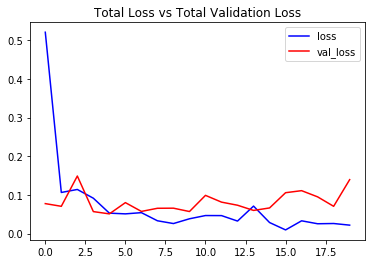

In [30]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

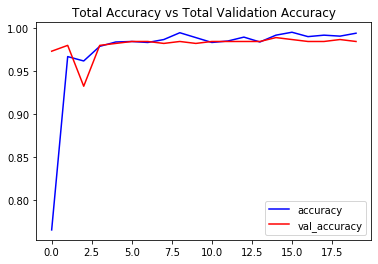

In [31]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [32]:
### Save model in a folder 
RootFolder

'C:/1-GG/CAP4/EventDetection/1-ExampleSetting/OutputFiles'

In [33]:
# Saving Model
model_name = 'video combined_video-2vdo model_jj.h5'
model.save(RootFolder+'/'+model_name)

### How to load the model from disk

In [34]:
RootFolder

'C:/1-GG/CAP4/EventDetection/1-ExampleSetting/OutputFiles'

In [35]:
model_name = 'video combined_video-2vdo model_jj.h5'



In [36]:
from tensorflow import keras

model = keras.models.load_model(RootFolder+'/'+model_name)


#### Here

### Evaluating our Video Classification Model


In [37]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
from tqdm import tqdm
from keras.applications.vgg16 import VGG16
import cv2
import math
import os
from glob import glob
from scipy import stats as s

from moviepy.editor import *   ###VideoFileClip


## pafy, youtube-dl and moviepy packages to be installed
##pip install pafy youtube-dl moviepy

## Install open cv - make sure numpy already installed
#pip install opencv-python
#import pafy

In [38]:
# read testFrames csv
testFrames  = pd.read_csv(RootFolder+"/testFrames.csv")
testFrames.shape

(319, 3)

In [39]:
testFrames.head()

,FrameFilename,FullPathName,class
0,v_Basketball_g01_c01.avi,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,Basketball
1,v_Basketball_g01_c01.avi,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,Basketball
2,v_Basketball_g01_c01.avi,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,Basketball
3,v_Basketball_g01_c01.avi,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,Basketball
4,v_Basketball_g01_c01.avi,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,Basketball


In [40]:
# Extract each vdo from testFrames 
testSetVDOlist = testFrames["FrameFilename"].tolist()
print(testSetVDOlist)

['v_Basketball_g01_c01.avi', 'v_Basketball_g01_c01.avi', 'v_Basketball_g01_c01.avi', 'v_Basketball_g01_c01.avi', 'v_Basketball_g01_c01.avi', 'v_Basketball_g01_c02.avi', 'v_Basketball_g01_c02.avi', 'v_Basketball_g01_c02.avi', 'v_Basketball_g01_c02.avi', 'v_Basketball_g01_c02.avi', 'v_Basketball_g01_c02.avi', 'v_Basketball_g01_c02.avi', 'v_Basketball_g01_c03.avi', 'v_Basketball_g01_c03.avi', 'v_Basketball_g01_c03.avi', 'v_Basketball_g01_c03.avi', 'v_Basketball_g01_c03.avi', 'v_Basketball_g01_c03.avi', 'v_Basketball_g01_c03.avi', 'v_Basketball_g01_c03.avi', 'v_Basketball_g01_c04.avi', 'v_Basketball_g01_c04.avi', 'v_Basketball_g01_c04.avi', 'v_Basketball_g01_c04.avi', 'v_Basketball_g01_c05.avi', 'v_Basketball_g01_c05.avi', 'v_Basketball_g01_c05.avi', 'v_Basketball_g01_c05.avi', 'v_Basketball_g01_c05.avi', 'v_Basketball_g01_c06.avi', 'v_Basketball_g01_c06.avi', 'v_Basketball_g01_c06.avi', 'v_Basketball_g01_c06.avi', 'v_Basketball_g01_c06.avi', 'v_Basketball_g01_c06.avi', 'v_Basketball_g01_c

In [41]:
print(len(testSetVDOlist))

# Remove Duplicates From vdo list - as a vdo file has many frame images
testSetVDOlist = list(dict.fromkeys(testSetVDOlist))
print(len(testSetVDOlist))
 

319
76


In [42]:
testSetVDOlist

['v_Basketball_g01_c01.avi',
 'v_Basketball_g01_c02.avi',
 'v_Basketball_g01_c03.avi',
 'v_Basketball_g01_c04.avi',
 'v_Basketball_g01_c05.avi',
 'v_Basketball_g01_c06.avi',
 'v_Basketball_g01_c07.avi',
 'v_Basketball_g02_c01.avi',
 'v_Basketball_g02_c02.avi',
 'v_Basketball_g02_c03.avi',
 'v_Basketball_g02_c04.avi',
 'v_Basketball_g02_c05.avi',
 'v_Basketball_g02_c06.avi',
 'v_Basketball_g03_c01.avi',
 'v_Basketball_g03_c02.avi',
 'v_Basketball_g03_c03.avi',
 'v_Basketball_g03_c04.avi',
 'v_Basketball_g03_c05.avi',
 'v_Basketball_g03_c06.avi',
 'v_Basketball_g04_c01.avi',
 'v_Basketball_g04_c02.avi',
 'v_Basketball_g04_c03.avi',
 'v_Basketball_g04_c04.avi',
 'v_Basketball_g05_c01.avi',
 'v_Basketball_g05_c02.avi',
 'v_Basketball_g05_c03.avi',
 'v_Basketball_g05_c04.avi',
 'v_Basketball_g06_c01.avi',
 'v_Basketball_g06_c02.avi',
 'v_Basketball_g06_c03.avi',
 'v_Basketball_g06_c04.avi',
 'v_Basketball_g07_c01.avi',
 'v_Basketball_g07_c02.avi',
 'v_Basketball_g07_c03.avi',
 'v_Basketball

In [43]:
# separating the target
# To map the predicted categories with the actual categories, we will use train frame class:
y = trainFrames['class']
y = pd.get_dummies(y)

In [44]:
y

,Basketball,SoccerPenalty
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
2762,0,1
2763,0,1
2764,0,1
2765,0,1


### Example

In [45]:
testSetVDOlist[1]

'v_Basketball_g01_c02.avi'

In [46]:
temp_df = testFrames.loc[(testFrames.FrameFilename == testSetVDOlist[1])]
temp_df.head()

,FrameFilename,FullPathName,class
5,v_Basketball_g01_c02.avi,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,Basketball
6,v_Basketball_g01_c02.avi,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,Basketball
7,v_Basketball_g01_c02.avi,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,Basketball
8,v_Basketball_g01_c02.avi,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,Basketball
9,v_Basketball_g01_c02.avi,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,Basketball


In [47]:
temp_df = temp_df.reset_index(drop=True)  # reset index
temp_df.head()

,FrameFilename,FullPathName,class
0,v_Basketball_g01_c02.avi,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,Basketball
1,v_Basketball_g01_c02.avi,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,Basketball
2,v_Basketball_g01_c02.avi,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,Basketball
3,v_Basketball_g01_c02.avi,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,Basketball
4,v_Basketball_g01_c02.avi,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,Basketball


In [48]:
print(temp_df['class'][0])

Basketball


In [49]:

    
for i in range(len(testSetVDOlist)):
    print(testSetVDOlist[i])
    temp_df = testFrames.loc[(testFrames.FrameFilename == testSetVDOlist[i])]
    temp_df = temp_df.reset_index(drop=True)  # reset index
    print(temp_df['class'][0])
    #print(temp_df.shape)

v_Basketball_g01_c01.avi
Basketball
v_Basketball_g01_c02.avi
Basketball
v_Basketball_g01_c03.avi
Basketball
v_Basketball_g01_c04.avi
Basketball
v_Basketball_g01_c05.avi
Basketball
v_Basketball_g01_c06.avi
Basketball
v_Basketball_g01_c07.avi
Basketball
v_Basketball_g02_c01.avi
Basketball
v_Basketball_g02_c02.avi
Basketball
v_Basketball_g02_c03.avi
Basketball
v_Basketball_g02_c04.avi
Basketball
v_Basketball_g02_c05.avi
Basketball
v_Basketball_g02_c06.avi
Basketball
v_Basketball_g03_c01.avi
Basketball
v_Basketball_g03_c02.avi
Basketball
v_Basketball_g03_c03.avi
Basketball
v_Basketball_g03_c04.avi
Basketball
v_Basketball_g03_c05.avi
Basketball
v_Basketball_g03_c06.avi
Basketball
v_Basketball_g04_c01.avi
Basketball
v_Basketball_g04_c02.avi
Basketball
v_Basketball_g04_c03.avi
Basketball
v_Basketball_g04_c04.avi
Basketball
v_Basketball_g05_c01.avi
Basketball
v_Basketball_g05_c02.avi
Basketball
v_Basketball_g05_c03.avi
Basketball
v_Basketball_g05_c04.avi
Basketball
v_Basketball_g06_c01.avi
Bas

In [50]:
#print(temp_df['class'][i])
temp_df.head()

,FrameFilename,FullPathName,class
0,v_SoccerPenalty_g07_c06.avi,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,SoccerPenalty
1,v_SoccerPenalty_g07_c06.avi,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,SoccerPenalty
2,v_SoccerPenalty_g07_c06.avi,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,SoccerPenalty
3,v_SoccerPenalty_g07_c06.avi,C:/1-GG/CAP4/EventDetection/1-ExampleSetting\V...,SoccerPenalty


### end of Example

In [59]:
# for loop to read and store test frames
# creating two lists to store predicted and actual tags
predict = []
actual = []
indent_variable   = []

for i in range(len(testSetVDOlist)):
    #print(testSetVDOlist[i])
    temp_df = testFrames.loc[(testFrames.FrameFilename == testSetVDOlist[i])] # all frames of a particular vdo
    temp_df = temp_df.reset_index(drop=True)  # reset index
    #print(temp_df.shape)  
   
    prediction_images = []
    
    # appending the actual class of the video
    
    actual.append(temp_df['class'][0])
    #print("Actual:" , actual)

    # appending the vdo file name as indent
    indent_variable.append(temp_df['FrameFilename'][0])
    #print("Indent:" ,indent_variable)

    for i in tqdm(range(temp_df.shape[0])):  ### Loop through all frames of a particular vdo
        
 
        # loading the image and keeping the target size as (224,224,3)
        img = image.load_img(temp_df['FullPathName'][i], target_size=(224,224,3))
        # converting it to array
        img = image.img_to_array(img)
        # normalizing the pixel value
        img = img/255
        # appending the image to the image list
        prediction_images.append(img)
        #print("Prediction:" , prediction_images)
        
    # converting the list to numpy array
    prediction_images = np.array(prediction_images)

    # extracting features using pre-trained model
    prediction_images = base_model.predict(prediction_images)

    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*512)

    # predicting class for each array.
    # predict_classes() function on model in order to predict the class values for each instance in the array.
    prediction = model.predict_classes(prediction_images)
    #print("Prediction:" , prediction)
    # appending the mode of predictions (Class that occurs on highest frrequency) in predict list to assign the class to the video
    predict.append(y.columns.values[s.mode(prediction)[0][0]])



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 832.86it/s]


Prediction: [0 0 0 0 0]


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1000.58it/s]


Prediction: [0 0 0 0 0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 889.24it/s]


Prediction: [0 0 0 0 1 0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 666.66it/s]


Prediction: [0 0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.52it/s]


Prediction: [0 0 0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 599.81it/s]


Prediction: [0 0 0 0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 571.12it/s]


Prediction: [0 0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.74it/s]


Prediction: [0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.86it/s]


Prediction: [0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 570.96it/s]


Prediction: [0 0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 750.01it/s]


Prediction: [0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.18it/s]


Prediction: [0 0 0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.61it/s]


Prediction: [0 0 0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.93it/s]


Prediction: [0 0 0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 416.94it/s]


Prediction: [0 0 0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 416.74it/s]


Prediction: [0 0 0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 375.07it/s]


Prediction: [0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 357.08it/s]


Prediction: [0 0 0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 600.50it/s]


Prediction: [0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 363.52it/s]


Prediction: [0 0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 499.90it/s]


Prediction: [1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 500.11it/s]


Prediction: [1 0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 299.77it/s]


Prediction: [0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 384.33it/s]


Prediction: [0 0 0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 444.29it/s]


Prediction: [0 0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 444.38it/s]


Prediction: [0 0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 428.59it/s]


Prediction: [0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 300.06it/s]


Prediction: [0 0 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 500.38it/s]


Prediction: [0 0 1 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 333.27it/s]


Prediction: [0 0 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 300.06it/s]


Prediction: [0 1 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.38it/s]


Prediction: [0 0 0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 266.68it/s]


Prediction: [0 0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 428.61it/s]


Prediction: [0 0 0 0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 499.87it/s]


Prediction: [0 0 0 0]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.54it/s]


Prediction: [1 1 1 1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 352.52it/s]


Prediction: [1 1 1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 400.19it/s]


Prediction: [1 1 1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 285.56it/s]


Prediction: [1 1 1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.95it/s]


Prediction: [1 1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 571.55it/s]


Prediction: [1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.46it/s]


Prediction: [1 1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 571.55it/s]


Prediction: [1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 500.04it/s]


Prediction: [1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 714.39it/s]


Prediction: [1 1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 571.66it/s]


Prediction: [1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 799.83it/s]


Prediction: [1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 799.91it/s]


Prediction: [1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 600.19it/s]


Prediction: [1 1 1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 666.53it/s]


Prediction: [1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 749.74it/s]


Prediction: [1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 499.90it/s]


Prediction: [1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 600.19it/s]


Prediction: [1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 600.39it/s]


Prediction: [1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 666.56it/s]


Prediction: [1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.84it/s]


Prediction: [1 1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 666.50it/s]


Prediction: [1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 799.52it/s]


Prediction: [1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 666.50it/s]


Prediction: [1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 666.61it/s]


Prediction: [1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 800.67it/s]


Prediction: [1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 599.87it/s]


Prediction: [1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 857.29it/s]


Prediction: [1 1 1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.82it/s]


Prediction: [1 1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 666.82it/s]


Prediction: [1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 750.05it/s]


Prediction: [1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 500.14it/s]


Prediction: [1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 500.14it/s]


Prediction: [1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 800.10it/s]


Prediction: [1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 599.73it/s]


Prediction: [1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 599.39it/s]


Prediction: [1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 749.70it/s]


Prediction: [1 1 1 1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 749.92it/s]


Prediction: [1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 998.72it/s]


Prediction: [1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 600.01it/s]


Prediction: [1 1 1]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 799.94it/s]


Prediction: [1 1 1 1]


In [60]:
prediction


array([1, 1, 1, 1], dtype=int64)

In [61]:
y.columns.values[s.mode(prediction)[0][0]]

'SoccerPenalty'

In [62]:
# Calling DataFrame constructor after zipping
# both lists, with columns specified
EvalFinalOutput = pd.DataFrame(list(zip(indent_variable, actual ,predict )),
               columns =['VdOFileName', 'ActualClass' , 'PredictedClass'])
EvalFinalOutput

,VdOFileName,ActualClass,PredictedClass
0,v_Basketball_g01_c01.avi,Basketball,Basketball
1,v_Basketball_g01_c02.avi,Basketball,Basketball
2,v_Basketball_g01_c03.avi,Basketball,Basketball
3,v_Basketball_g01_c04.avi,Basketball,Basketball
4,v_Basketball_g01_c05.avi,Basketball,Basketball
...,...,...,...
71,v_SoccerPenalty_g07_c02.avi,SoccerPenalty,SoccerPenalty
72,v_SoccerPenalty_g07_c03.avi,SoccerPenalty,SoccerPenalty
73,v_SoccerPenalty_g07_c04.avi,SoccerPenalty,SoccerPenalty
74,v_SoccerPenalty_g07_c05.avi,SoccerPenalty,SoccerPenalty


In [64]:
print(y_test)
from sklearn.metrics import classification_report
classification_metrics = classification_report(y_test,prediction, target_names = ["Basketball","SoccerPenalty"])
print(classification_metrics)

      Basketball  SoccerPenalty
1874           0              1
2404           0              1
2750           0              1
1858           0              1
744            1              0
...          ...            ...
624            1              0
600            1              0
540            1              0
1808           0              1
1597           0              1

[554 rows x 2 columns]


ValueError: Found input variables with inconsistent numbers of samples: [554, 4]

In [75]:
EvalFinalOutput.to_csv(RootFolder+'/EvalFinalOutput.csv',header=True, index=False)